In [1]:
# pip install -U pymoo

In [2]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors

from smt.sampling_methods import LHS
from smt.applications.mixed_integer import (
    FLOAT,
    ORD,
    ENUM,
    MixedIntegerSamplingMethod,
)
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from mpl_toolkits.mplot3d import Axes3D

from smt.surrogate_models import KRG
from smt.sampling_methods import LHS, Random
from smt.applications.mixed_integer import MixedIntegerContext, FLOAT, ORD, ENUM
from pymoo.core.problem import ElementwiseProblem
from pymoo.core.variable import Real, Integer, Choice, Binary
from pymoo.core.mixed import MixedVariableGA
from pymoo.core.variable import Real, Integer
from pymoo.optimize import minimize
from pymoo.core.problem import ElementwiseProblem
from pymoo.core.variable import Real, Integer, Choice, Binary
from pymoo.algorithms.soo.nonconvex.de import DE
from pymoo.constraints.as_penalty import ConstraintsAsPenalty
from pymoo.optimize import minimize
from pymoo.core.evaluator import Evaluator
from pymoo.core.individual import Individual
from pymoo.core.problem import ElementwiseProblem

import time

In [3]:
def goldstein(x):
    return (1+(x[:,0]+x[:,1]+1) ** 2 * (19- 14 * x[:,0]+ 3 * x[:,0] ** 2- 14* x[:,1]+6 * x[:,0] * x[:,1]+3 * x[:,1] ** 2))*(30+((2*x[:,0]-3*x[:,1])** 2)*(18-32*x[:,0]+12*x[:,0]**2+48*x[:,1]-36*x[:,0]*x[:,1]+27*x[:,1]**2))
# context to create consistent DOEs and surrogate

In [4]:
def pererr(ytest,ypred):
    from sklearn.metrics import mean_absolute_error
    er=mean_absolute_error(ytest, ypred)
    return er
def presserrors(model,x,y):
    import numpy as np
    from sklearn.metrics import r2_score
    from sklearn.model_selection import LeaveOneOut
    from sklearn.metrics import mean_squared_error
    loo = LeaveOneOut()
    y_preds=[]
    y_org=[]
    for train_idx, test_idx in loo.split(x):
        X_train, X_test = x[train_idx], x[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        model.set_training_values(X_train, y_train)
        model.train()
        model.print_prediction=[False]
        y_pred = model.predict_values(X_test)
        y_org.append(y_test)
        print(y_pred)
        y_pred=y_pred.flatten()
        y_preds.append(y_pred)   
    # calculate the RMS error over all folds
    press_rms = np.sqrt(mean_squared_error(y_org, y_preds))
    press_r2= 1-np.sum(np.subtract(y_org,y_preds)**2)/np.sum((y_org - np.mean(y))**2)
    sk_r2=r2_score(y_org,y_preds)
    per_MAE=pererr(y_org,y_preds)
    print(press_rms,'PRESS % RMS')
    print(sk_r2,'sk_r2')
    print(press_r2,' PRESS R2')
    print(per_MAE,'PRESS % MAE')
    return

In [5]:
# def rosenbrock(x): 
#     return 100*(x[:,1]-x[:,0]**2)**2+(x[:,0]-1)**2

DOE point nb = 140
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 17
   
   Predicting ...
   Predicting - done. Time (sec):  0.0009632
   
   Prediction time/pt. (sec) :  0.0000567
   


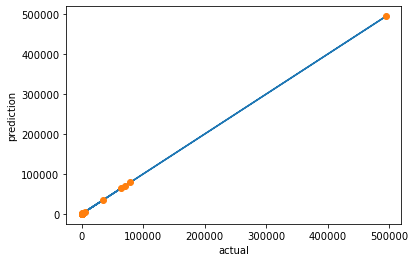

In [6]:
## Building surrogate models in mixed space with GP kernel


## Original bounds
xtypes = [FLOAT, ORD]
xlimits = [[-2.0, 2.0], [-2,2]]
sampling = MixedIntegerSamplingMethod(xtypes, xlimits, LHS, criterion="ese")

# def ftest(x):
#     return (x[:, 0] * x[:, 0] + x[:, 1] * x[:, 1]) * (x[:, 2] + 1)

# def ftest(x):
#     return (1+(x[:,0]+x[:,1]+1) ** 2 * (19- 14 * x[:,0]+ 3 * x[:,0] ** 2- 14* x[:,1]+6 * x[:,0] * x[:,1]+3 * x[:,1] ** 2))*(30+((2*x[:,0]-3*x[:,1])** 2)*(18-32*x[:,0]+12*x[:,0]**2+48*x[:,1]-36*x[:,0]*x[:,1]+27*x[:,1]**2))
# context to create consistent DOEs and surrogate
# print_prediction=[False]
# print_global=[False]
mixint = MixedIntegerContext(xtypes, xlimits)

# DOE for training
lhs = mixint.build_sampling_method(LHS, criterion="ese")
n=70
num = mixint.get_unfolded_dimension() *n #(n*d points for DoE generation)
print("DOE point nb = {}".format(num))
xt1 = lhs(num)
yt1 = goldstein(xt1)

# Surrogate
sm1 = mixint.build_surrogate_model(KRG())
sm1.set_training_values(xt1, yt1)
sm1.train()
sm1.print_prediction=[False]
# DOE for validation
rand = mixint.build_sampling_method(Random)
xv = rand(int(n/4)) #evaluating on n points
yv = goldstein(xv)
yp = sm1.predict_values(xv)

plt.plot(yv, yv)
plt.plot(yv, yp, "o")
plt.xlabel("actual")
plt.ylabel("prediction")

plt.show()

In [7]:
## Surrogate model accuracy

from sklearn.metrics import r2_score
import sklearn.metrics 

r2error1 = r2_score(yv, yp)
print('R2 Error in SM1',r2error1)

mse1 = sklearn.metrics.mean_squared_error(yv, yp)  
  
rmse1 = math.sqrt(mse1) 
print('RMSE Error in SM1',rmse1)

R2 Error in SM1 0.9999999999993171
RMSE Error in SM1 0.09555054828280748


In [8]:

#Optimization of  Metamodel using pymoo Surr 1
class MixedVariableProblem1(ElementwiseProblem):

    def __init__(self, **kwargs):
        vars = {
            "x": Real(bounds=(-2,2)),
            "z": Integer(bounds=(-2,2)),
        }
        super().__init__(vars=vars, n_obj=1, **kwargs)

        
    def _evaluate(self, x,out, *args, **kwargs):
        x1,x2=x["x"],x["z"]
        xx=np.array([[x1,x2]])
        y=sm1.predict_values(xx)
        out["F"]= y

In [9]:
#Optimization of  Metamodel using pymoo Surr 1
from pymoo.algorithms.soo.nonconvex.pso import PSO
from pymoo.problems import get_problem
from pymoo.optimize import minimize
from pymoo.core.callback import Callback
# from pymoo.factory import get_termination
from pymoo.termination.ftol import MultiObjectiveSpaceTermination
from pymoo.termination.robust import RobustTermination

termination = RobustTermination(MultiObjectiveSpaceTermination(tol=0.01), period=20)
problem = MixedVariableProblem1()

class MyCallback(Callback):

    def __init__(self) -> None:
        super().__init__()
        self.n_evals = []
        self.opt = []
        self.allev=[]

    def notify(self, algorithm):
        self.n_evals.append(algorithm.evaluator.n_eval)
        self.opt.append(algorithm.opt[0].F)
        self.allev.append(algorithm.opt[0].F)

callback1 = MyCallback()


algorithm = MixedVariableGA(pop=20)

import time
start_time = time.time()
res = minimize(ConstraintsAsPenalty(problem, penalty=1000.0),
               algorithm,
               callback=callback1,
#                termination=('n_gen',25)
               termination=termination,
               seed=1,
               verbose=False,save_history=True)

print("Best solution found: \nX = %s\nF = %s" % (res.X, res.F))


end_time = time.time()
elapsed_time = end_time - start_time


___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 1
   
   Predicting ...
   Predicting - done. Time (sec):  0.0009975
   
   Prediction time/pt. (sec) :  0.0009975
   
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 1
   
   Predicting ...
   Predicting - done. Time (sec):  0.0000000
   
   Prediction time/pt. (sec) :  0.0000000
   
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 1
   
   Predicting ...
   Predicting - done. Time (sec):  0.0000000
   
   Prediction time/pt. (sec) :  0.0000000
   
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 1
   
   Predicting ...
   Predicting - done. Time (sec):  0.0010250
   
   Prediction time/pt. (sec) :  0.0010250
   
________________________________________________

   Predicting - done. Time (sec):  0.0009968
   
   Prediction time/pt. (sec) :  0.0009968
   
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 1
   
   Predicting ...
   Predicting - done. Time (sec):  0.0000000
   
   Prediction time/pt. (sec) :  0.0000000
   
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 1
   
   Predicting ...
   Predicting - done. Time (sec):  0.0009992
   
   Prediction time/pt. (sec) :  0.0009992
   
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 1
   
   Predicting ...
   Predicting - done. Time (sec):  0.0000000
   
   Prediction time/pt. (sec) :  0.0000000
   
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 1
   
   Predicting ...
   Predicting - done. Time (sec):  0.0000000
   

   Predicting - done. Time (sec):  0.0009980
   
   Prediction time/pt. (sec) :  0.0009980
   
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 1
   
   Predicting ...
   Predicting - done. Time (sec):  0.0009985
   
   Prediction time/pt. (sec) :  0.0009985
   
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 1
   
   Predicting ...
   Predicting - done. Time (sec):  0.0000000
   
   Prediction time/pt. (sec) :  0.0000000
   
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 1
   
   Predicting ...
   Predicting - done. Time (sec):  0.0009954
   
   Prediction time/pt. (sec) :  0.0009954
   
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 1
   
   Predicting ...
   Predicting - done. Time (sec):  0.0000000
   

   
      # eval points. : 1
   
   Predicting ...
   Predicting - done. Time (sec):  0.0010207
   
   Prediction time/pt. (sec) :  0.0010207
   
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 1
   
   Predicting ...
   Predicting - done. Time (sec):  0.0000000
   
   Prediction time/pt. (sec) :  0.0000000
   
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 1
   
   Predicting ...
   Predicting - done. Time (sec):  0.0009735
   
   Prediction time/pt. (sec) :  0.0009735
   
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 1
   
   Predicting ...
   Predicting - done. Time (sec):  0.0000000
   
   Prediction time/pt. (sec) :  0.0000000
   
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 1
   
   Predicting .

___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 1
   
   Predicting ...
   Predicting - done. Time (sec):  0.0010276
   
   Prediction time/pt. (sec) :  0.0010276
   
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 1
   
   Predicting ...
   Predicting - done. Time (sec):  0.0000000
   
   Prediction time/pt. (sec) :  0.0000000
   
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 1
   
   Predicting ...
   Predicting - done. Time (sec):  0.0000000
   
   Prediction time/pt. (sec) :  0.0000000
   
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 1
   
   Predicting ...
   Predicting - done. Time (sec):  0.0000000
   
   Prediction time/pt. (sec) :  0.0000000
   
________________________________________________

   Predicting - done. Time (sec):  0.0009961
   
   Prediction time/pt. (sec) :  0.0009961
   
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 1
   
   Predicting ...
   Predicting - done. Time (sec):  0.0000000
   
   Prediction time/pt. (sec) :  0.0000000
   
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 1
   
   Predicting ...
   Predicting - done. Time (sec):  0.0000000
   
   Prediction time/pt. (sec) :  0.0000000
   
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 1
   
   Predicting ...
   Predicting - done. Time (sec):  0.0013831
   
   Prediction time/pt. (sec) :  0.0013831
   
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 1
   
   Predicting ...
   Predicting - done. Time (sec):  0.0009754
   

___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 1
   
   Predicting ...
   Predicting - done. Time (sec):  0.0000000
   
   Prediction time/pt. (sec) :  0.0000000
   
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 1
   
   Predicting ...
   Predicting - done. Time (sec):  0.0000000
   
   Prediction time/pt. (sec) :  0.0000000
   
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 1
   
   Predicting ...
   Predicting - done. Time (sec):  0.0009966
   
   Prediction time/pt. (sec) :  0.0009966
   
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 1
   
   Predicting ...
   Predicting - done. Time (sec):  0.0000000
   
   Prediction time/pt. (sec) :  0.0000000
   
________________________________________________

___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 1
   
   Predicting ...
   Predicting - done. Time (sec):  0.0009696
   
   Prediction time/pt. (sec) :  0.0009696
   
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 1
   
   Predicting ...
   Predicting - done. Time (sec):  0.0035818
   
   Prediction time/pt. (sec) :  0.0035818
   
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 1
   
   Predicting ...
   Predicting - done. Time (sec):  0.0010254
   
   Prediction time/pt. (sec) :  0.0010254
   
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 1
   
   Predicting ...
   Predicting - done. Time (sec):  0.0009971
   
   Prediction time/pt. (sec) :  0.0009971
   
________________________________________________

___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 1
   
   Predicting ...
   Predicting - done. Time (sec):  0.0010252
   
   Prediction time/pt. (sec) :  0.0010252
   
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 1
   
   Predicting ...
   Predicting - done. Time (sec):  0.0000000
   
   Prediction time/pt. (sec) :  0.0000000
   
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 1
   
   Predicting ...
   Predicting - done. Time (sec):  0.0002916
   
   Prediction time/pt. (sec) :  0.0002916
   
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 1
   
   Predicting ...
   Predicting - done. Time (sec):  0.0007055
   
   Prediction time/pt. (sec) :  0.0007055
   
________________________________________________

___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 1
   
   Predicting ...
   Predicting - done. Time (sec):  0.0010381
   
   Prediction time/pt. (sec) :  0.0010381
   
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 1
   
   Predicting ...
   Predicting - done. Time (sec):  0.0009940
   
   Prediction time/pt. (sec) :  0.0009940
   
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 1
   
   Predicting ...
   Predicting - done. Time (sec):  0.0000000
   
   Prediction time/pt. (sec) :  0.0000000
   
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 1
   
   Predicting ...
   Predicting - done. Time (sec):  0.0000000
   
   Prediction time/pt. (sec) :  0.0000000
   
________________________________________________

___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 1
   
   Predicting ...
   Predicting - done. Time (sec):  0.0000000
   
   Prediction time/pt. (sec) :  0.0000000
   
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 1
   
   Predicting ...
   Predicting - done. Time (sec):  0.0009985
   
   Prediction time/pt. (sec) :  0.0009985
   
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 1
   
   Predicting ...
   Predicting - done. Time (sec):  0.0000000
   
   Prediction time/pt. (sec) :  0.0000000
   
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 1
   
   Predicting ...
   Predicting - done. Time (sec):  0.0000000
   
   Prediction time/pt. (sec) :  0.0000000
   
________________________________________________

___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 1
   
   Predicting ...
   Predicting - done. Time (sec):  0.0009980
   
   Prediction time/pt. (sec) :  0.0009980
   
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 1
   
   Predicting ...
   Predicting - done. Time (sec):  0.0000000
   
   Prediction time/pt. (sec) :  0.0000000
   
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 1
   
   Predicting ...
   Predicting - done. Time (sec):  0.0009973
   
   Prediction time/pt. (sec) :  0.0009973
   
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 1
   
   Predicting ...
   Predicting - done. Time (sec):  0.0009980
   
   Prediction time/pt. (sec) :  0.0009980
   
________________________________________________

___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 1
   
   Predicting ...
   Predicting - done. Time (sec):  0.0009935
   
   Prediction time/pt. (sec) :  0.0009935
   
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 1
   
   Predicting ...
   Predicting - done. Time (sec):  0.0000000
   
   Prediction time/pt. (sec) :  0.0000000
   
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 1
   
   Predicting ...
   Predicting - done. Time (sec):  0.0009365
   
   Prediction time/pt. (sec) :  0.0009365
   
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 1
   
   Predicting ...
   Predicting - done. Time (sec):  0.0000000
   
   Prediction time/pt. (sec) :  0.0000000
   
________________________________________________

___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 1
   
   Predicting ...
   Predicting - done. Time (sec):  0.0009971
   
   Prediction time/pt. (sec) :  0.0009971
   
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 1
   
   Predicting ...
   Predicting - done. Time (sec):  0.0000000
   
   Prediction time/pt. (sec) :  0.0000000
   
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 1
   
   Predicting ...
   Predicting - done. Time (sec):  0.0009973
   
   Prediction time/pt. (sec) :  0.0009973
   
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 1
   
   Predicting ...
   Predicting - done. Time (sec):  0.0000000
   
   Prediction time/pt. (sec) :  0.0000000
   
________________________________________________

   Predicting - done. Time (sec):  0.0004699
   
   Prediction time/pt. (sec) :  0.0004699
   
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 1
   
   Predicting ...
   Predicting - done. Time (sec):  0.0009975
   
   Prediction time/pt. (sec) :  0.0009975
   
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 1
   
   Predicting ...
   Predicting - done. Time (sec):  0.0000000
   
   Prediction time/pt. (sec) :  0.0000000
   
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 1
   
   Predicting ...
   Predicting - done. Time (sec):  0.0000000
   
   Prediction time/pt. (sec) :  0.0000000
   
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 1
   
   Predicting ...
   Predicting - done. Time (sec):  0.0000000
   

   Predicting ...
   Predicting - done. Time (sec):  0.0020757
   
   Prediction time/pt. (sec) :  0.0020757
   
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 1
   
   Predicting ...
   Predicting - done. Time (sec):  0.0000000
   
   Prediction time/pt. (sec) :  0.0000000
   
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 1
   
   Predicting ...
   Predicting - done. Time (sec):  0.0000000
   
   Prediction time/pt. (sec) :  0.0000000
   
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 1
   
   Predicting ...
   Predicting - done. Time (sec):  0.0000000
   
   Prediction time/pt. (sec) :  0.0000000
   
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 1
   
   Predicting ...
   Predicting - done. Time (se

      # eval points. : 1
   
   Predicting ...
   Predicting - done. Time (sec):  0.0000000
   
   Prediction time/pt. (sec) :  0.0000000
   
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 1
   
   Predicting ...
   Predicting - done. Time (sec):  0.0000000
   
   Prediction time/pt. (sec) :  0.0000000
   
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 1
   
   Predicting ...
   Predicting - done. Time (sec):  0.0009985
   
   Prediction time/pt. (sec) :  0.0009985
   
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 1
   
   Predicting ...
   Predicting - done. Time (sec):  0.0006166
   
   Prediction time/pt. (sec) :  0.0006166
   
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 1
   
   Predicting ...
 

___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 1
   
   Predicting ...
   Predicting - done. Time (sec):  0.0000000
   
   Prediction time/pt. (sec) :  0.0000000
   
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 1
   
   Predicting ...
   Predicting - done. Time (sec):  0.0010686
   
   Prediction time/pt. (sec) :  0.0010686
   
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 1
   
   Predicting ...
   Predicting - done. Time (sec):  0.0000656
   
   Prediction time/pt. (sec) :  0.0000656
   
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 1
   
   Predicting ...
   Predicting - done. Time (sec):  0.0010257
   
   Prediction time/pt. (sec) :  0.0010257
   
________________________________________________

___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 1
   
   Predicting ...
   Predicting - done. Time (sec):  0.0000000
   
   Prediction time/pt. (sec) :  0.0000000
   
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 1
   
   Predicting ...
   Predicting - done. Time (sec):  0.0000000
   
   Prediction time/pt. (sec) :  0.0000000
   
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 1
   
   Predicting ...
   Predicting - done. Time (sec):  0.0000000
   
   Prediction time/pt. (sec) :  0.0000000
   
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 1
   
   Predicting ...
   Predicting - done. Time (sec):  0.0000000
   
   Prediction time/pt. (sec) :  0.0000000
   
________________________________________________

___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 1
   
   Predicting ...
   Predicting - done. Time (sec):  0.0000000
   
   Prediction time/pt. (sec) :  0.0000000
   
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 1
   
   Predicting ...
   Predicting - done. Time (sec):  0.0000000
   
   Prediction time/pt. (sec) :  0.0000000
   
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 1
   
   Predicting ...
   Predicting - done. Time (sec):  0.0009222
   
   Prediction time/pt. (sec) :  0.0009222
   
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 1
   
   Predicting ...
   Predicting - done. Time (sec):  0.0000000
   
   Prediction time/pt. (sec) :  0.0000000
   
________________________________________________

___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 1
   
   Predicting ...
   Predicting - done. Time (sec):  0.0000000
   
   Prediction time/pt. (sec) :  0.0000000
   
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 1
   
   Predicting ...
   Predicting - done. Time (sec):  0.0009983
   
   Prediction time/pt. (sec) :  0.0009983
   
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 1
   
   Predicting ...
   Predicting - done. Time (sec):  0.0000000
   
   Prediction time/pt. (sec) :  0.0000000
   
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 1
   
   Predicting ...
   Predicting - done. Time (sec):  0.0000000
   
   Prediction time/pt. (sec) :  0.0000000
   
________________________________________________

In [10]:
print(f"Computational time: {elapsed_time} seconds")

Computational time: 3.650785207748413 seconds


In [11]:

# Access the population at each generation
solutions_per_generation = []
for generation in res.history:
    solutions_per_generation.append((generation.pop.get("X"), generation.pop.get("F")))

# Print the solutions obtained at each generation
pergen=[]
mean_pergen=[]
best_pergen=[]
std_pergen=[]
for i, (X, F) in enumerate(solutions_per_generation):
    pergen.append(F)
for i in range(10,len(pergen)):
    mean_pergen.append(np.mean(pergen[i]))
    best_pergen.append(np.min(pergen[i]))
    std_pergen.append(np.std(pergen[i]))
# In this 

In [12]:
import matplotlib as mpl
mpl.rc('font',family='Times New Roman')

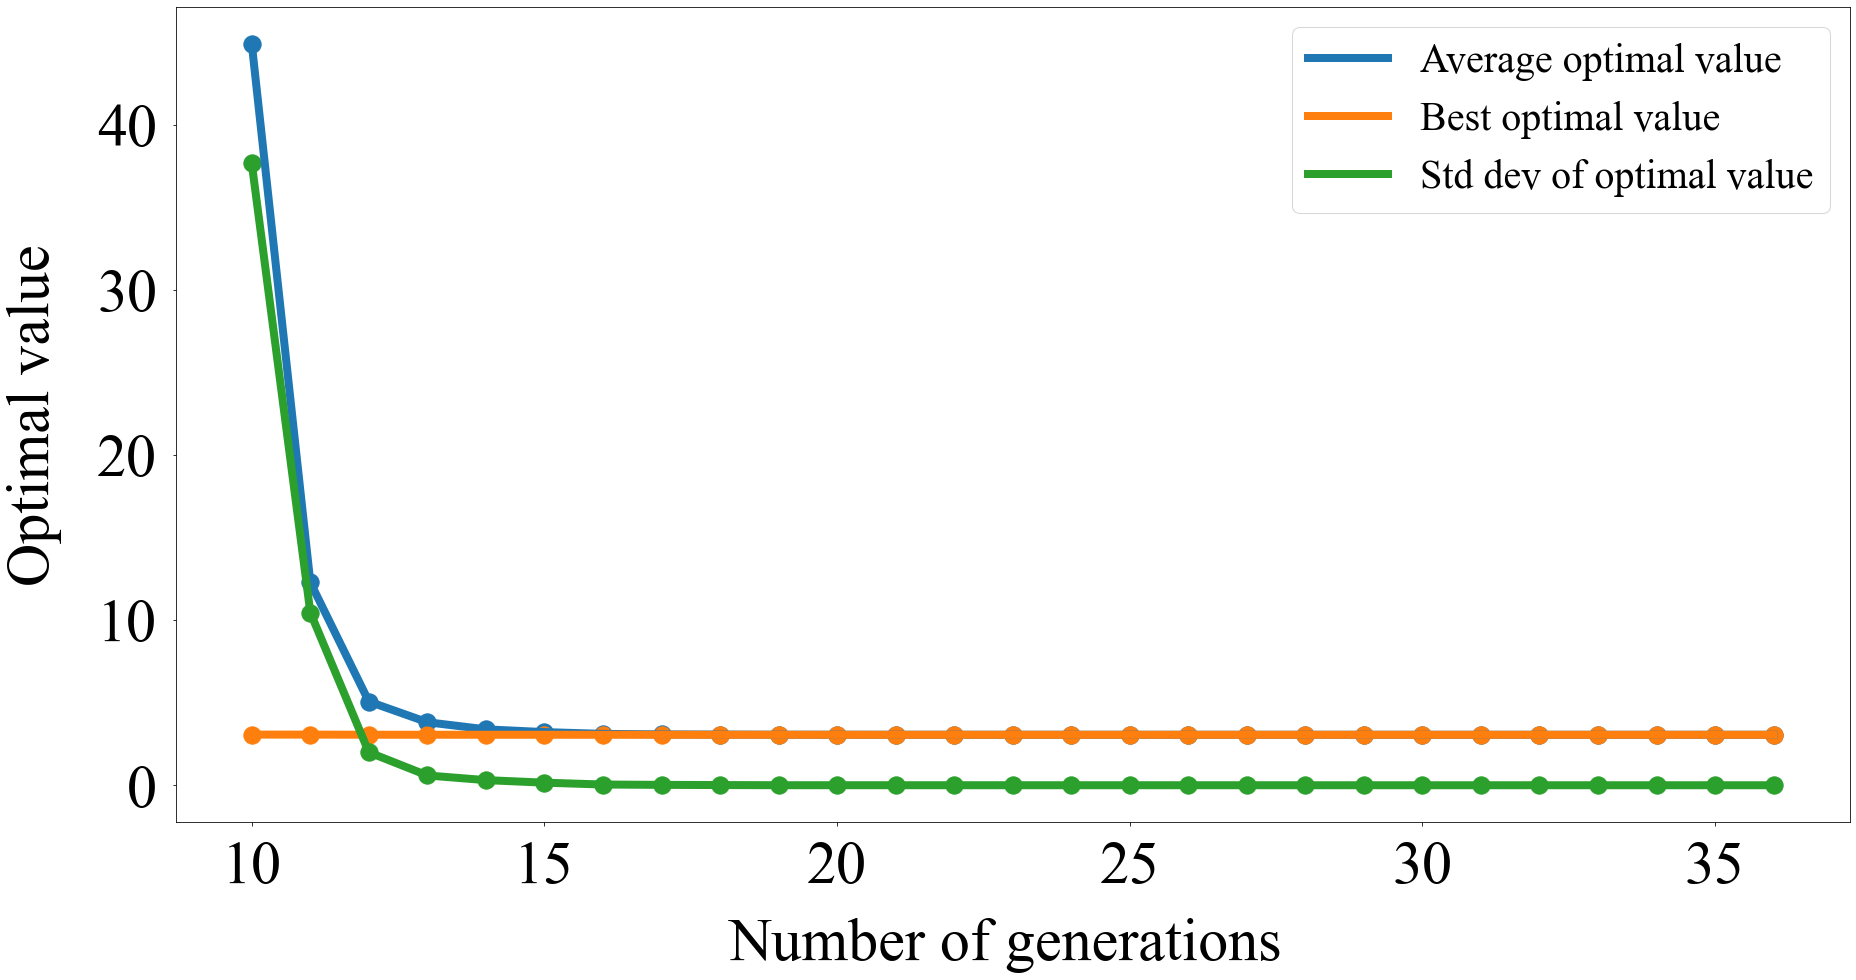

In [13]:
x=np.arange(10,len(pergen))

fig, ax = plt.subplots(figsize=(30,15))
# plt.title("Convergence",fontsize=28,pad=20)
plt.ylabel("Optimal value",fontsize=60,labelpad=35)
plt.xlabel("Number of generations ",fontsize=60,labelpad=22)
ax.plot(x,mean_pergen,label="Average optimal value",lw=8)
ax.plot(x,best_pergen,label="Best optimal value",lw=8)
ax.plot(x,std_pergen,label="Std dev of optimal value",lw=8)
ax.scatter(x,mean_pergen,s=300)
ax.scatter(x,best_pergen,s=300)
ax.scatter(x,std_pergen,s=300)
plt.legend(fontsize=40)
# plt.yscale("log")
# plt.gca().invert_yaxis()
plt.tick_params(axis='both', labelsize=60,colors ='k',pad=15)
# plt.xlim(left=3)
# plt.yticks(np.arange(-1,2, 1))

In [14]:
print('Minima value with Surrogate model 2 is at',res.X,'and value is',res.F)

Minima value with Surrogate model 2 is at {'x': -0.00011125102695409145, 'z': -1} and value is [3.056375]


In [15]:
x.shape

(27,)

DOE point nb = 30
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 3
   
   Predicting ...
   Predicting - done. Time (sec):  0.0009642
   
   Prediction time/pt. (sec) :  0.0003214
   


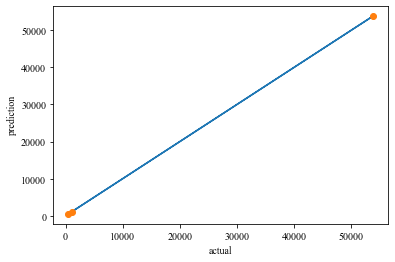

In [16]:
## Building surrogate models in mixed space with GP kernel

## modified bounds after viz surrogate model

xtypes = [FLOAT, ORD]
xlimits = [[-0.8, 2.0], [-2,0]]
sampling = MixedIntegerSamplingMethod(xtypes, xlimits, LHS, criterion="ese")
mixint = MixedIntegerContext(xtypes, xlimits)

# DOE for training
lhs = mixint.build_sampling_method(LHS, criterion="ese")
n=15
num = mixint.get_unfolded_dimension()*n #(n*d points for DoE generation)
print("DOE point nb = {}".format(num))
xt = lhs(num)
yt = goldstein(xt)

# Surrogate
sm2 = mixint.build_surrogate_model(KRG())
sm2.set_training_values(xt, yt)
sm2.train()
sm2.print_prediction=[False]
# DOE for validation
rand = mixint.build_sampling_method(Random)
xv = rand(int(n/4)) #evaluating on n points
yv = goldstein(xv)
yp = sm2.predict_values(xv)

plt.plot(yv, yv)
plt.plot(yv, yp, "o")
plt.xlabel("actual")
plt.ylabel("prediction")

plt.show()

In [17]:
# RMSE error for modifide bounds

from sklearn.metrics import r2_score
import sklearn.metrics 

r2error1 = r2_score(yv, yp)
print('R2 Error in SM1',r2error1)

mse1 = sklearn.metrics.mean_squared_error(yv, yp)  
  
rmse1 = math.sqrt(mse1) 
print('RMSE Error in SM1',rmse1)

R2 Error in SM1 0.9999997240621431
RMSE Error in SM1 13.127364012970585


In [18]:

#Optimization of  Metamodel using pymoo
## modified bounds after viz surrogate model 2
class MixedVariableProblem2(ElementwiseProblem):

    def __init__(self, **kwargs):
        vars = {
            "x": Real(bounds=(-0.9,2)),
            "z": Integer(bounds=(-2,0)),
        }
        super().__init__(vars=vars, n_obj=1, **kwargs)

        
    def _evaluate(self, x,out, *args, **kwargs):
        x1,x2=x["x"],x["z"]
        xx=np.array([[x1,x2]])
        y=sm2.predict_values(xx)
        out["F"]= y

In [19]:
# Solving with orginal function
#optimization with pymoo
from pymoo.algorithms.soo.nonconvex.pso import PSO
from pymoo.problems import get_problem
from pymoo.optimize import minimize
from pymoo.core.callback import Callback
from pymoo.termination.ftol import MultiObjectiveSpaceTermination
from pymoo.termination.robust import RobustTermination

termination = RobustTermination(MultiObjectiveSpaceTermination(tol=0.01), period=20)

class MyCallback(Callback):

    def __init__(self) -> None:
        super().__init__()
        self.n_evals = []
        self.opt = []

    def notify(self, algorithm):
        self.n_evals.append(algorithm.evaluator.n_eval)
        self.opt.append(algorithm.opt[0].F)


# problem = get_problem("ackley")
# algorithm = PSO()
callback2 = MyCallback()


problem = MixedVariableProblem2()


algorithm = MixedVariableGA(pop=20)

import time
start_time = time.time()
import time
start_time = time.time()
res1 = minimize(ConstraintsAsPenalty(problem, penalty=100.0),
               algorithm,
               callback=callback2,
#                termination=('n_gen', 25)
               termination=termination,
               seed=2,
               verbose=False,save_history=True)

print("Best solution found: \nX = %s\nF = %s" % (res1.X, res1.F))
end_time = time.time()
elapsed_time = end_time - start_time



___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 1
   
   Predicting ...
   Predicting - done. Time (sec):  0.0020766
   
   Prediction time/pt. (sec) :  0.0020766
   
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 1
   
   Predicting ...
   Predicting - done. Time (sec):  0.0024350
   
   Prediction time/pt. (sec) :  0.0024350
   
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 1
   
   Predicting ...
   Predicting - done. Time (sec):  0.0000000
   
   Prediction time/pt. (sec) :  0.0000000
   
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 1
   
   Predicting ...
   Predicting - done. Time (sec):  0.0007365
   
   Prediction time/pt. (sec) :  0.0007365
   
________________________________________________

   Predicting - done. Time (sec):  0.0009980
   
   Prediction time/pt. (sec) :  0.0009980
   
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 1
   
   Predicting ...
   Predicting - done. Time (sec):  0.0000000
   
   Prediction time/pt. (sec) :  0.0000000
   
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 1
   
   Predicting ...
   Predicting - done. Time (sec):  0.0000000
   
   Prediction time/pt. (sec) :  0.0000000
   
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 1
   
   Predicting ...
   Predicting - done. Time (sec):  0.0009980
   
   Prediction time/pt. (sec) :  0.0009980
   
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 1
   
   Predicting ...
   Predicting - done. Time (sec):  0.0005195
   

   Predicting - done. Time (sec):  0.0010605
   
   Prediction time/pt. (sec) :  0.0010605
   
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 1
   
   Predicting ...
   Predicting - done. Time (sec):  0.0000000
   
   Prediction time/pt. (sec) :  0.0000000
   
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 1
   
   Predicting ...
   Predicting - done. Time (sec):  0.0000000
   
   Prediction time/pt. (sec) :  0.0000000
   
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 1
   
   Predicting ...
   Predicting - done. Time (sec):  0.0003428
   
   Prediction time/pt. (sec) :  0.0003428
   
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 1
   
   Predicting ...
   Predicting - done. Time (sec):  0.0000000
   

___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 1
   
   Predicting ...
   Predicting - done. Time (sec):  0.0000000
   
   Prediction time/pt. (sec) :  0.0000000
   
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 1
   
   Predicting ...
   Predicting - done. Time (sec):  0.0000000
   
   Prediction time/pt. (sec) :  0.0000000
   
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 1
   
   Predicting ...
   Predicting - done. Time (sec):  0.0015893
   
   Prediction time/pt. (sec) :  0.0015893
   
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 1
   
   Predicting ...
   Predicting - done. Time (sec):  0.0000000
   
   Prediction time/pt. (sec) :  0.0000000
   
________________________________________________

   Predicting - done. Time (sec):  0.0013785
   
   Prediction time/pt. (sec) :  0.0013785
   
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 1
   
   Predicting ...
   Predicting - done. Time (sec):  0.0009716
   
   Prediction time/pt. (sec) :  0.0009716
   
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 1
   
   Predicting ...
   Predicting - done. Time (sec):  0.0004365
   
   Prediction time/pt. (sec) :  0.0004365
   
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 1
   
   Predicting ...
   Predicting - done. Time (sec):  0.0005209
   
   Prediction time/pt. (sec) :  0.0005209
   
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 1
   
   Predicting ...
   Predicting - done. Time (sec):  0.0009861
   

   Predicting - done. Time (sec):  0.0009954
   
   Prediction time/pt. (sec) :  0.0009954
   
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 1
   
   Predicting ...
   Predicting - done. Time (sec):  0.0000000
   
   Prediction time/pt. (sec) :  0.0000000
   
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 1
   
   Predicting ...
   Predicting - done. Time (sec):  0.0009701
   
   Prediction time/pt. (sec) :  0.0009701
   
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 1
   
   Predicting ...
   Predicting - done. Time (sec):  0.0003910
   
   Prediction time/pt. (sec) :  0.0003910
   
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 1
   
   Predicting ...
   Predicting - done. Time (sec):  0.0000000
   

   Predicting - done. Time (sec):  0.0013251
   
   Prediction time/pt. (sec) :  0.0013251
   
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 1
   
   Predicting ...
   Predicting - done. Time (sec):  0.0002489
   
   Prediction time/pt. (sec) :  0.0002489
   
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 1
   
   Predicting ...
   Predicting - done. Time (sec):  0.0000000
   
   Prediction time/pt. (sec) :  0.0000000
   
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 1
   
   Predicting ...
   Predicting - done. Time (sec):  0.0010819
   
   Prediction time/pt. (sec) :  0.0010819
   
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 1
   
   Predicting ...
   Predicting - done. Time (sec):  0.0000000
   

   Predicting - done. Time (sec):  0.0007708
   
   Prediction time/pt. (sec) :  0.0007708
   
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 1
   
   Predicting ...
   Predicting - done. Time (sec):  0.0004511
   
   Prediction time/pt. (sec) :  0.0004511
   
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 1
   
   Predicting ...
   Predicting - done. Time (sec):  0.0008643
   
   Prediction time/pt. (sec) :  0.0008643
   
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 1
   
   Predicting ...
   Predicting - done. Time (sec):  0.0000000
   
   Prediction time/pt. (sec) :  0.0000000
   
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 1
   
   Predicting ...
   Predicting - done. Time (sec):  0.0009527
   

___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 1
   
   Predicting ...
   Predicting - done. Time (sec):  0.0009985
   
   Prediction time/pt. (sec) :  0.0009985
   
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 1
   
   Predicting ...
   Predicting - done. Time (sec):  0.0006490
   
   Prediction time/pt. (sec) :  0.0006490
   
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 1
   
   Predicting ...
   Predicting - done. Time (sec):  0.0000000
   
   Prediction time/pt. (sec) :  0.0000000
   
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 1
   
   Predicting ...
   Predicting - done. Time (sec):  0.0009964
   
   Prediction time/pt. (sec) :  0.0009964
   
________________________________________________

   Predicting - done. Time (sec):  0.0010014
   
   Prediction time/pt. (sec) :  0.0010014
   
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 1
   
   Predicting ...
   Predicting - done. Time (sec):  0.0009937
   
   Prediction time/pt. (sec) :  0.0009937
   
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 1
   
   Predicting ...
   Predicting - done. Time (sec):  0.0020435
   
   Prediction time/pt. (sec) :  0.0020435
   
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 1
   
   Predicting ...
   Predicting - done. Time (sec):  0.0005229
   
   Prediction time/pt. (sec) :  0.0005229
   
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 1
   
   Predicting ...
   Predicting - done. Time (sec):  0.0000000
   

   Predicting - done. Time (sec):  0.0005636
   
   Prediction time/pt. (sec) :  0.0005636
   
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 1
   
   Predicting ...
   Predicting - done. Time (sec):  0.0005822
   
   Prediction time/pt. (sec) :  0.0005822
   
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 1
   
   Predicting ...
   Predicting - done. Time (sec):  0.0000000
   
   Prediction time/pt. (sec) :  0.0000000
   
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 1
   
   Predicting ...
   Predicting - done. Time (sec):  0.0000000
   
   Prediction time/pt. (sec) :  0.0000000
   
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 1
   
   Predicting ...
   Predicting - done. Time (sec):  0.0002143
   

___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 1
   
   Predicting ...
   Predicting - done. Time (sec):  0.0004542
   
   Prediction time/pt. (sec) :  0.0004542
   
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 1
   
   Predicting ...
   Predicting - done. Time (sec):  0.0000000
   
   Prediction time/pt. (sec) :  0.0000000
   
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 1
   
   Predicting ...
   Predicting - done. Time (sec):  0.0000000
   
   Prediction time/pt. (sec) :  0.0000000
   
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 1
   
   Predicting ...
   Predicting - done. Time (sec):  0.0000000
   
   Prediction time/pt. (sec) :  0.0000000
   
________________________________________________

   Predicting - done. Time (sec):  0.0009112
   
   Prediction time/pt. (sec) :  0.0009112
   
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 1
   
   Predicting ...
   Predicting - done. Time (sec):  0.0000000
   
   Prediction time/pt. (sec) :  0.0000000
   
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 1
   
   Predicting ...
   Predicting - done. Time (sec):  0.0000000
   
   Prediction time/pt. (sec) :  0.0000000
   
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 1
   
   Predicting ...
   Predicting - done. Time (sec):  0.0010612
   
   Prediction time/pt. (sec) :  0.0010612
   
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 1
   
   Predicting ...
   Predicting - done. Time (sec):  0.0000000
   

   
   Predicting ...
   Predicting - done. Time (sec):  0.0009913
   
   Prediction time/pt. (sec) :  0.0009913
   
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 1
   
   Predicting ...
   Predicting - done. Time (sec):  0.0001585
   
   Prediction time/pt. (sec) :  0.0001585
   
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 1
   
   Predicting ...
   Predicting - done. Time (sec):  0.0011349
   
   Prediction time/pt. (sec) :  0.0011349
   
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 1
   
   Predicting ...
   Predicting - done. Time (sec):  0.0018971
   
   Prediction time/pt. (sec) :  0.0018971
   
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 1
   
   Predicting ...
   Predicting - done. Time

___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 1
   
   Predicting ...
   Predicting - done. Time (sec):  0.0011456
   
   Prediction time/pt. (sec) :  0.0011456
   
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 1
   
   Predicting ...
   Predicting - done. Time (sec):  0.0000000
   
   Prediction time/pt. (sec) :  0.0000000
   
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 1
   
   Predicting ...
   Predicting - done. Time (sec):  0.0000000
   
   Prediction time/pt. (sec) :  0.0000000
   
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 1
   
   Predicting ...
   Predicting - done. Time (sec):  0.0000000
   
   Prediction time/pt. (sec) :  0.0000000
   
________________________________________________

   Predicting - done. Time (sec):  0.0010240
   
   Prediction time/pt. (sec) :  0.0010240
   
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 1
   
   Predicting ...
   Predicting - done. Time (sec):  0.0009019
   
   Prediction time/pt. (sec) :  0.0009019
   
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 1
   
   Predicting ...
   Predicting - done. Time (sec):  0.0009887
   
   Prediction time/pt. (sec) :  0.0009887
   
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 1
   
   Predicting ...
   Predicting - done. Time (sec):  0.0000000
   
   Prediction time/pt. (sec) :  0.0000000
   
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 1
   
   Predicting ...
   Predicting - done. Time (sec):  0.0000000
   

In [20]:
print('Minima value with Surrogate model 2 is at',res1.X,'and value is',res1.F)
print(f"Computational time: {elapsed_time} seconds")

Minima value with Surrogate model 2 is at {'x': -0.0002632652875020915, 'z': -1} and value is [2.99446997]
Computational time: 2.5893170833587646 seconds


In [21]:

# Access the population at each generation
solutions_per_generation = []
for generation in res1.history:
    solutions_per_generation.append((generation.pop.get("X"), generation.pop.get("F")))

# Print the solutions obtained at each generation
pergen=[]
mean_pergen=[]
best_pergen=[]
std_pergen=[]
for i, (X, F) in enumerate(solutions_per_generation):
    pergen.append(F)
for i in range(10,len(pergen)):
    mean_pergen.append(np.mean(pergen[i]))
    best_pergen.append(np.min(pergen[i]))
    std_pergen.append(np.std(pergen[i]))
# In this 

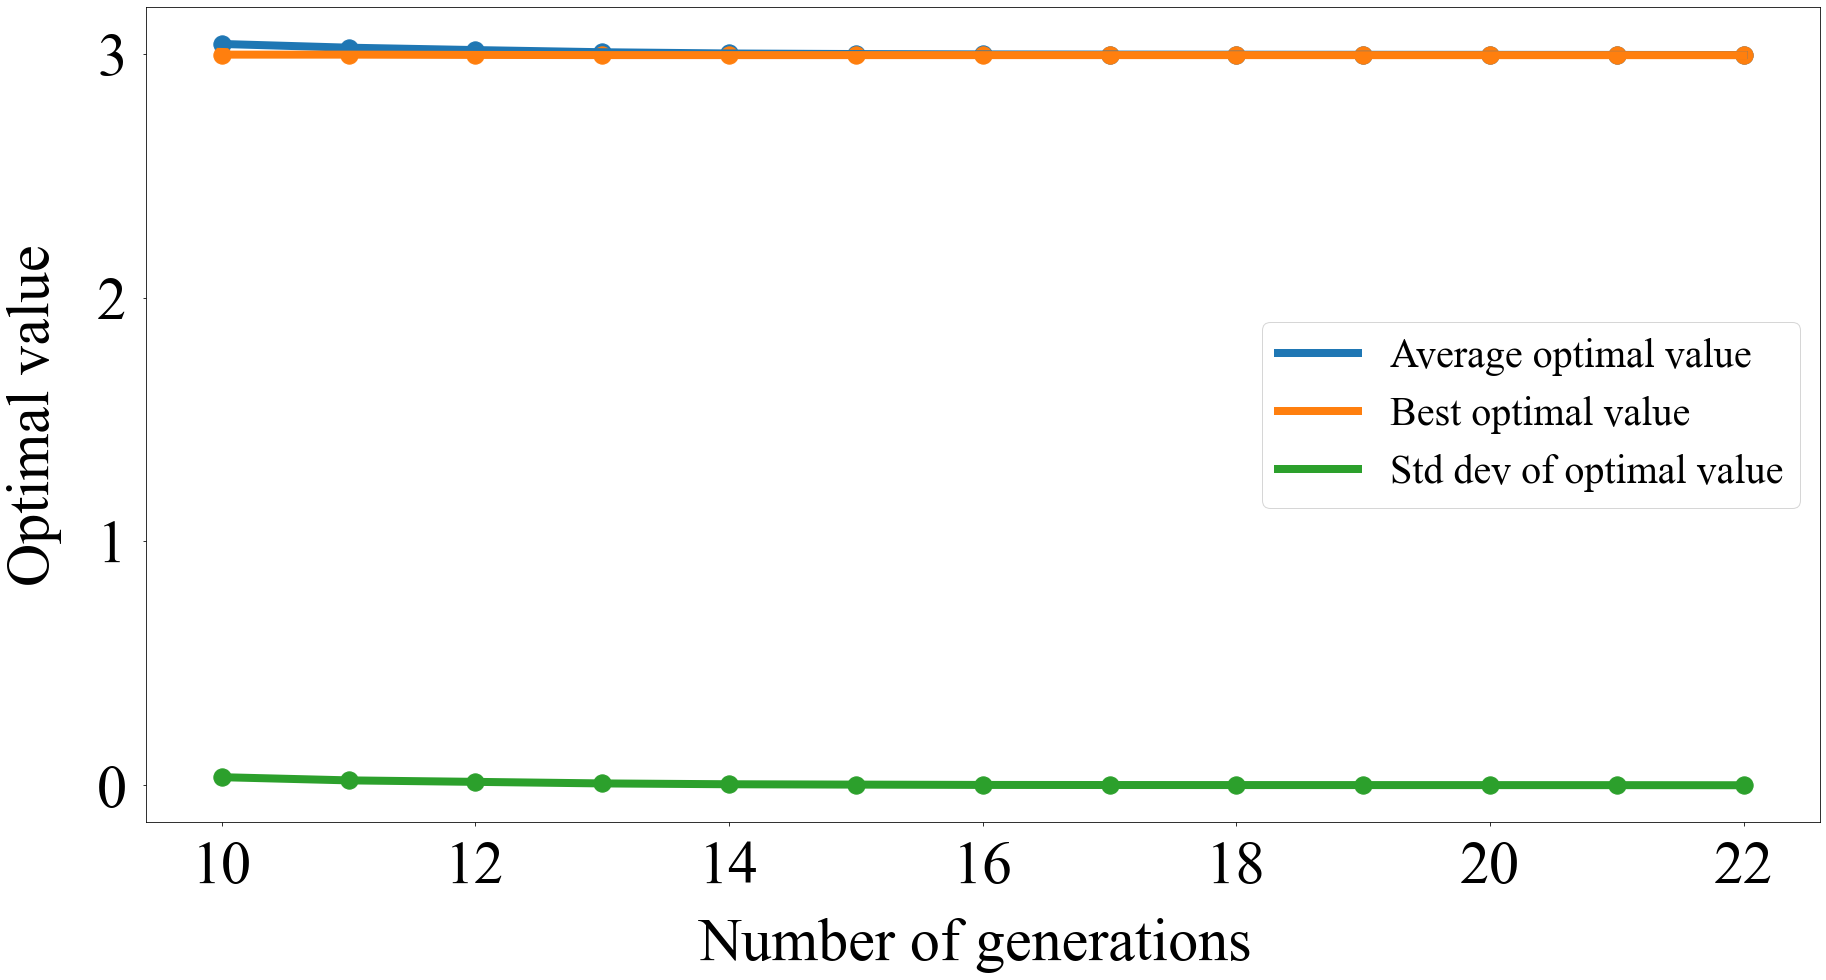

In [22]:
x=np.arange(10,len(pergen))

fig, ax = plt.subplots(figsize=(30,15))
# plt.title("Convergence",fontsize=28,pad=20)
plt.ylabel("Optimal value",fontsize=60,labelpad=35)
plt.xlabel("Number of generations ",fontsize=60,labelpad=22)
ax.plot(x,mean_pergen,label="Average optimal value",lw=8)
ax.plot(x,best_pergen,label="Best optimal value",lw=8)
ax.plot(x,std_pergen,label="Std dev of optimal value",lw=8)
ax.scatter(x,mean_pergen,s=300)
ax.scatter(x,best_pergen,s=300)
ax.scatter(x,std_pergen,s=300)
plt.legend(fontsize=40)
# plt.yscale("log")
# plt.gca().invert_yaxis()
plt.tick_params(axis='both', labelsize=60,colors ='k',pad=15)
# plt.xlim(left=3)
# plt.yticks(np.arange(-1,2, 1))

In [23]:
# presserrors(sm1,xt1,yt1)

In [24]:
presserrors(sm2,xt,yt)

___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 1
   
   Predicting ...
   Predicting - done. Time (sec):  0.0000000
   
   Prediction time/pt. (sec) :  0.0000000
   
[[22574.5148922]]
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 1
   
   Predicting ...
   Predicting - done. Time (sec):  0.0011046
   
   Prediction time/pt. (sec) :  0.0011046
   
[[1044.75854902]]
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 1
   
   Predicting ...
   Predicting - done. Time (sec):  0.0000000
   
   Prediction time/pt. (sec) :  0.0000000
   
[[125.53217197]]
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 1
   
   Predicting ...
   Predicting - done. Time (sec):  0.0000000
   
   Prediction time/pt. (sec) :  0.0000000

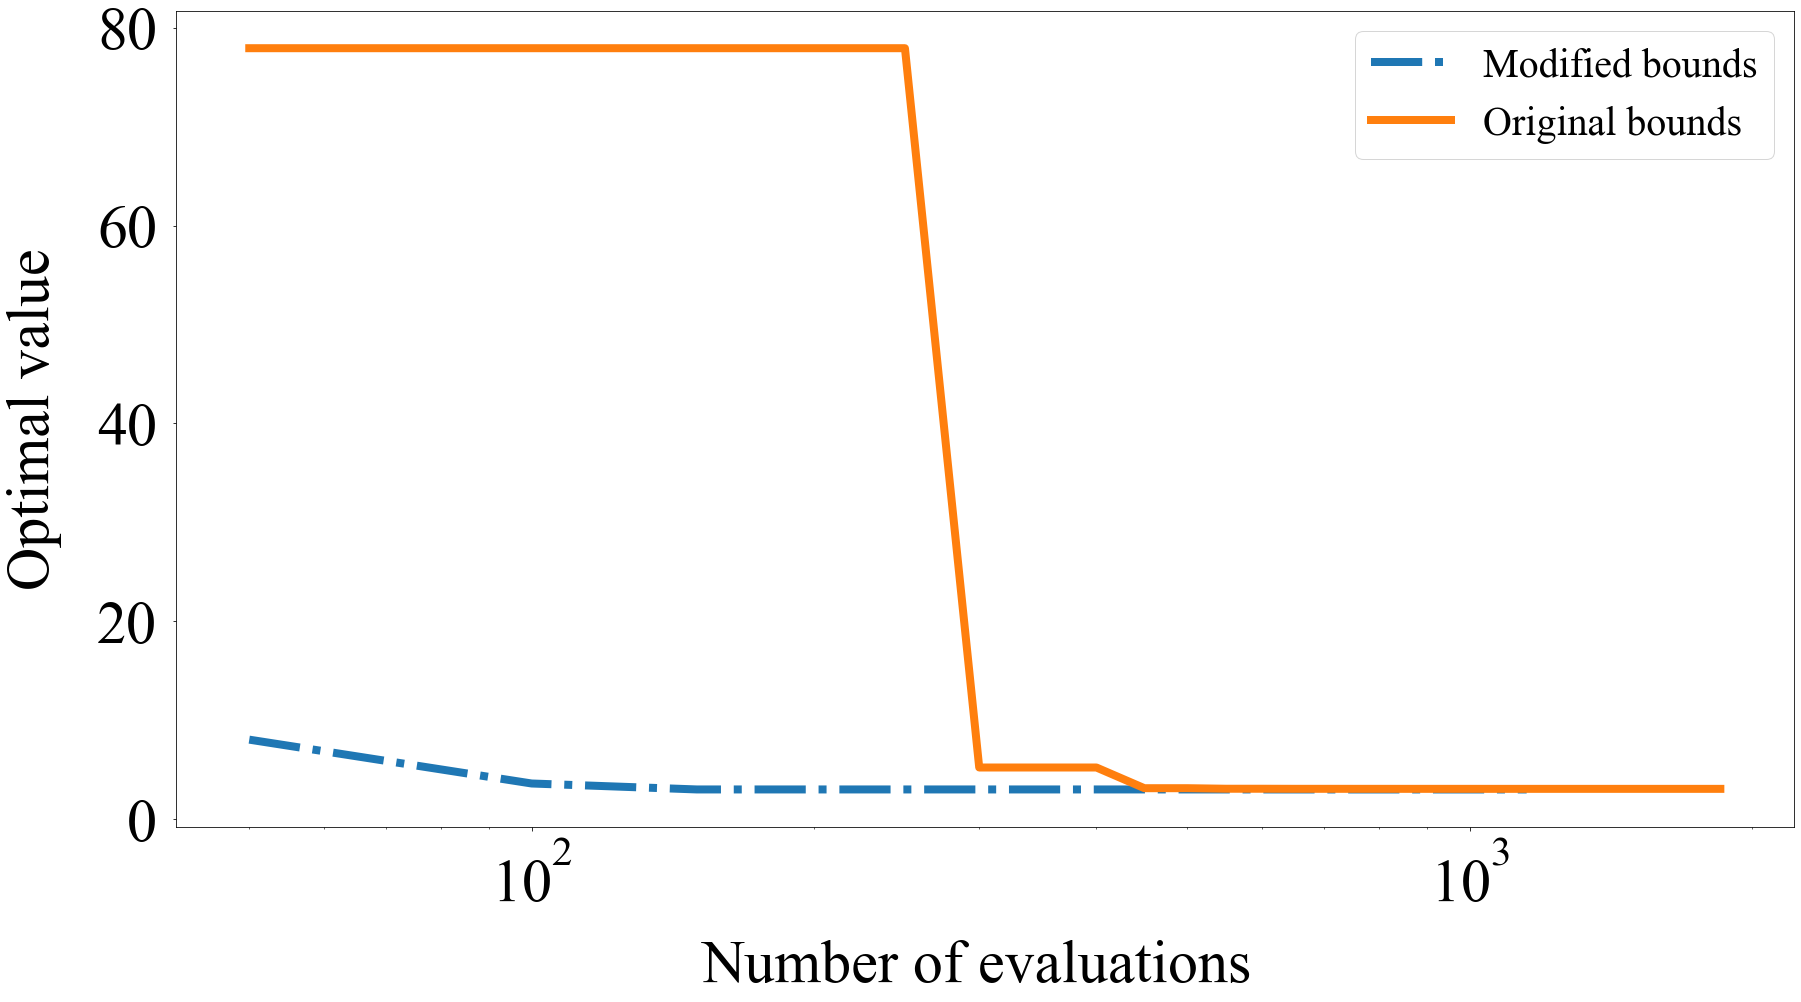

In [25]:
import matplotlib as mpl
mpl.rc('font',family='Times New Roman')
n_evals1 = np.array([e.evaluator.n_eval for e in res.history])
opt1 = np.array([e.opt[0].F for e in res.history])
n_evals2 = np.array([e.evaluator.n_eval for e in res1.history])
opt2 = np.array([e.opt[0].F for e in res1.history])
plt_1 = plt.figure(figsize=(29,15))
# plt.title("Convergence",fontsize=28,pad=20)
plt.ylabel("Optimal value",fontsize=60,labelpad=35)
plt.xlabel("Number of evaluations ",fontsize=60,labelpad=25)
plt.plot(n_evals2, opt2, "-.",label="Modified bounds",lw=8)
plt.plot(n_evals1, opt1, "",label="Original bounds",lw=8)
plt.legend(fontsize=40)
plt.tick_params(axis='both', labelsize=60,colors ='k',pad=15)
# plt.tick_params(axis='y', labelsize=12,colors ='k')
# plt.savefig("gold stein price chngd.png", dpi=1200)
plt.xscale("log")
plt.show()

In [26]:
# resF=[]
# resX=[]
import time
start_time = time.time()
# for i in range(50):
#     problem = MixedVariableProblem1()

    algorithm = MixedVariableGA(pop=20)

    res = minimize(ConstraintsAsPenalty(problem, penalty=100.0),
                   algorithm,
#                    termination=('n_gen', 25)
                   termination=termination,
                   verbose=False,save_history=True)
    resF.append(float(res.F))
    resX.append(list(res.X))
end_time = time.time()
elapsed_time = end_time - start_time

print(f"Computational time: {elapsed_time} seconds")

IndentationError: unexpected indent (<ipython-input-26-25709f3369e2>, line 8)

In [ ]:
print("Mean optimal value is \nMean=%s and standard deviation is \nStd=%s" % (np.average(resF),np.std(resF)))
print("Best solution found: \nX = %s\nF = %s" % (res.X, min(resF)))

In [ ]:
# res1F=[]
# res1X=[]
# import time
# start_time = time.time()
# for i in range(50):
    problem = MixedVariableProblem2()

    algorithm = MixedVariableGA(pop=20)

    res = minimize(ConstraintsAsPenalty(problem, penalty=100.0),
                   algorithm,
#                    termination=('n_gen',25)
                   termination=termination,
                   verbose=False,save_history=True)
    res1F.append(float(res.F))
    res1X.append(list(res.X))
    
end_time = time.time()
elapsed_time = end_time - start_time

print(f"Computational time: {elapsed_time} seconds")

In [ ]:
print("Mean optimal value is \nMean=%s and standard deviation is \nStd=%s" % (np.average(res1F),np.std(res1F)))
print("Best solution found: \nX = %s\nF = %s" % (res.X, min(res1F)))

In [ ]:
def cumulative_average(numbers):
    cumulative_sum = 0
    result = []

    for i, num in enumerate(numbers, 1):
        cumulative_sum += num
        average = cumulative_sum / i
        result.append(average)

    return result

In [ ]:
avg_old=cumulative_average(resF)
avg_new=cumulative_average(res1F)

In [ ]:
x=np.arange(len(avg_new))
plt_1 = plt.figure(figsize=(10,8))
# plt.title("Convergence",fontsize=28,pad=20)
plt.ylabel("Optimal value",fontsize=22,labelpad=22)
plt.xlabel("Number of simulations ",fontsize=22,labelpad=22)
plt.scatter(x,avg_new,label="Average optimal value")
plt.scatter(x,res1F,label="Best optimal value")
plt.legend(fontsize=16)
plt.tick_params(axis='both', labelsize=20,colors ='k',pad=15)
plt.yticks(np.arange(2,5, 1))

In [ ]:
x=np.arange(len(avg_new))
x=np.arange(len(avg_new))
plt_1 = plt.figure(figsize=(10,8))
# plt.title("Convergence",fontsize=28,pad=20)
plt.ylabel("Optimal value",fontsize=22,labelpad=22)
plt.xlabel("Number of simulations ",fontsize=22,labelpad=22)
plt.scatter(x,avg_old,label="Average optimal value")
plt.scatter(x,resF,label="Best optimal value")
plt.legend(fontsize=16)
plt.tick_params(axis='both', labelsize=20,colors ='k',pad=15)
plt.yticks(np.arange(2,5, 1))